# Mechanistic Interpretability applications

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

import seaborn as sns
sns.set_style("whitegrid")
from timm import create_model
import torch


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

__TO-DO__: Define your path to the project folder and ImageNet-S dataset here:

In [4]:
PROJ_PATH = []
DATASET_PATH =  []
CIFAR_PATH = []

In [6]:
# Define paths
PROJ_PATH = Path(PROJ_PATH)
DATASET_PATH = Path(DATASET_PATH)
CIFAR_PATH = Path(CIFAR_PATH)
RES_PATH = PROJ_PATH / 'results'

In [7]:
MODEL_MAP = {
    'vit_b_32': 'ViT-B/32',
    'vit_b_16': 'ViT-B/16',
    'vit_large_16': 'ViT-L/16',
    'vit_miil_16': 'ViT-B/16-MIIL',
    'vit_cifar_16': 'ViT-B/16-CIFAR',
    'deit_ensemble_16': 'ViT-B/16-Refinement',
    'vit_gap_16': 'ViT-B/16-GAP',
}

## Building categorical representations

To investigate the extent to which self-attention and MLP layers help build categorical representations, we measure the __class similarity change rate__ induced by these sub-modules.
Given a layer with input/output tokens and a class embedding matrix, we compute the proportion of output tokens whose correct class logits increase relative to the corresponding logits for input tokens, where all logits are obtained by projecting the tokens using the class embedding matrix.

Concretely, we projected the output of each layer $\mathbf{O}^{l}(\mathbf{X})$ to the class embedding space by $\mathbf{p}_{\text{out}}  = \mathbf{E} \cdot \mathbf{O}^l(\mathbf{X})^T$, and compared it to the projection of the input itself $\mathbf{p}_{\text{inp}} =\mathbf{E} \cdot \mathbf{X}^T$. 
We then compute the proportion of tokens $i$ where $p^i_{\text{out}} > p^i_{\text{inp}}$.

In [9]:
from src.plots.mech_interp import plot_class_building

#### ViT-B/32

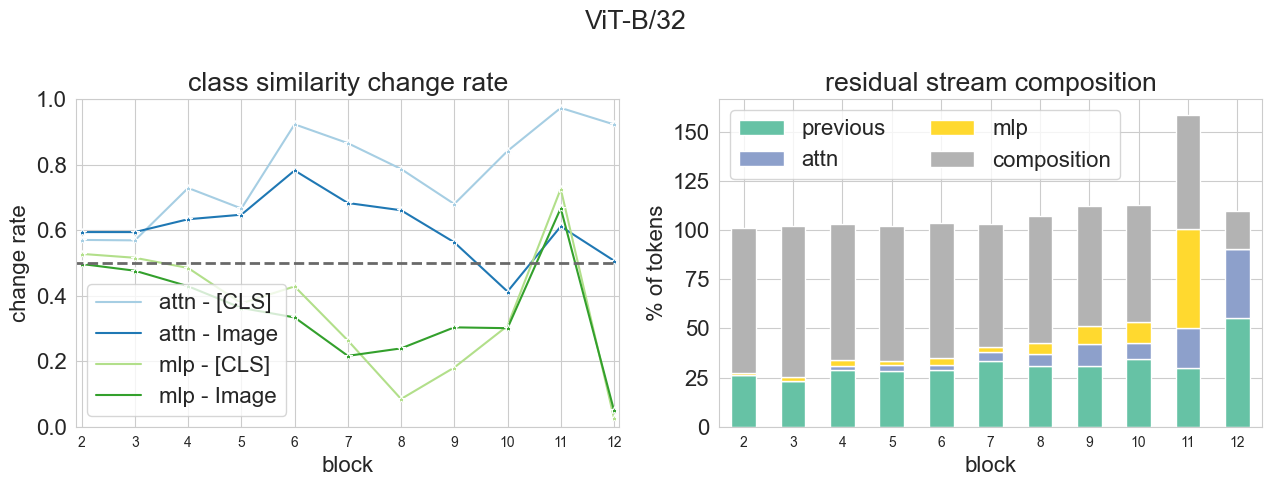

In [10]:
plot_class_building('vit_b_32', RES_PATH, DATASET_PATH)

#### ViT-B/16

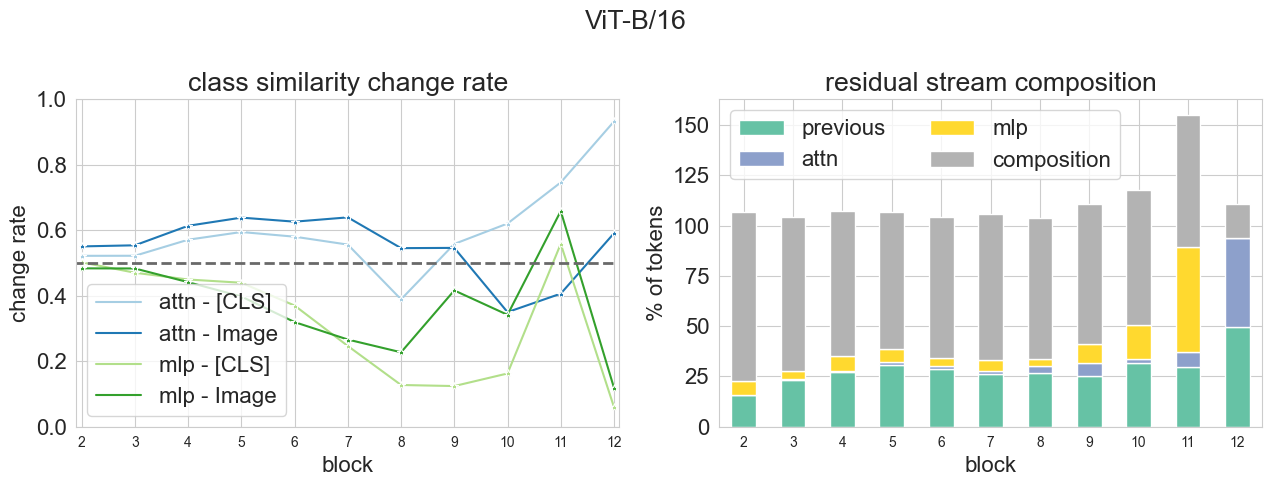

In [15]:
plot_class_building('vit_b_16', RES_PATH, DATASET_PATH)

#### ViT-L/16

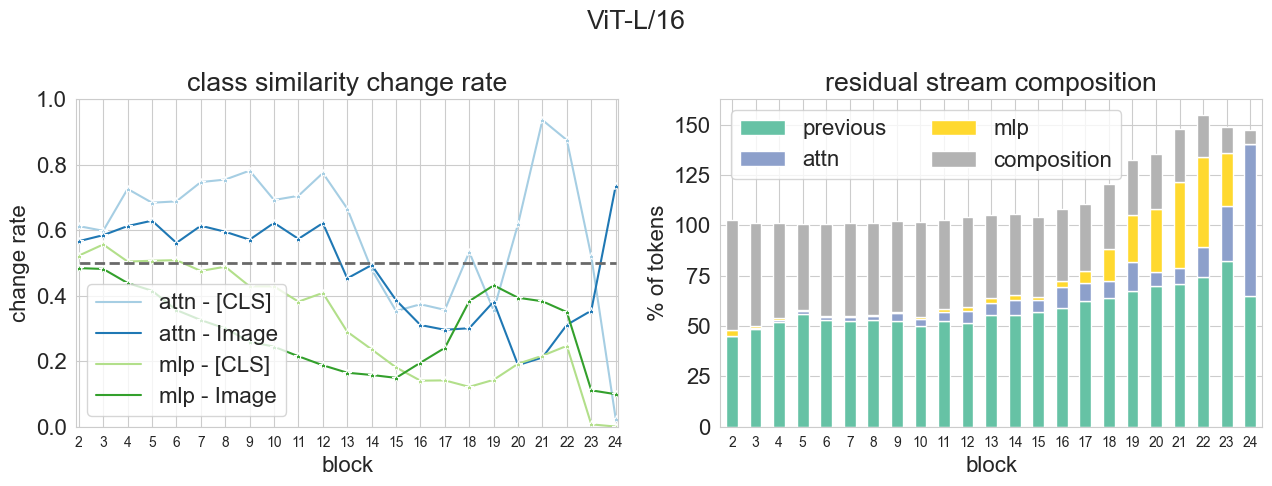

In [16]:
plot_class_building('vit_large_16', RES_PATH, DATASET_PATH)

#### ViT-B/16 - MILL

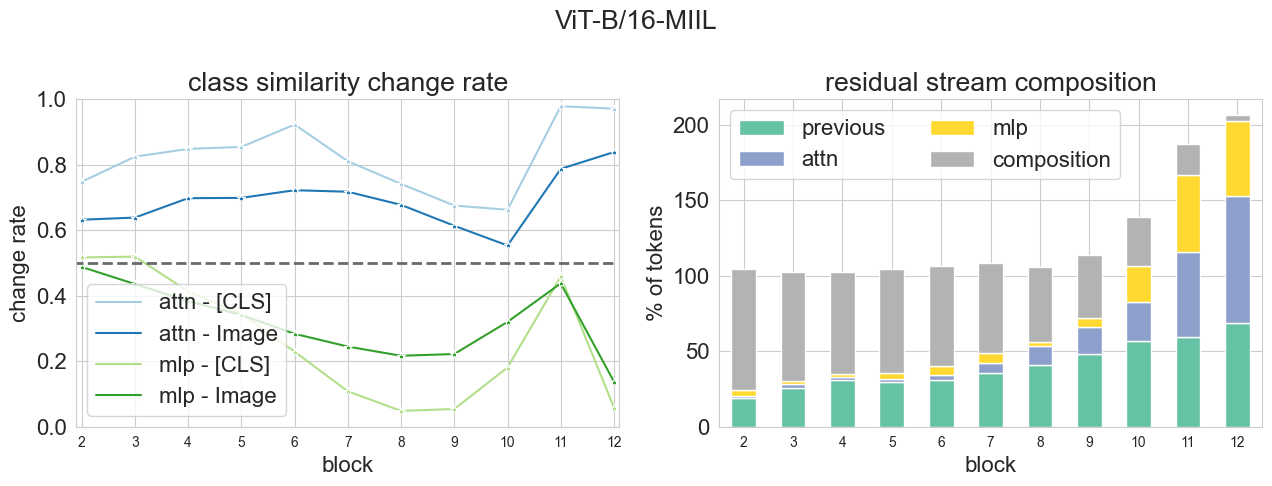

In [18]:
plot_class_building('vit_miil_16', RES_PATH, DATASET_PATH)

#### ViT-B/16 - CIFAR

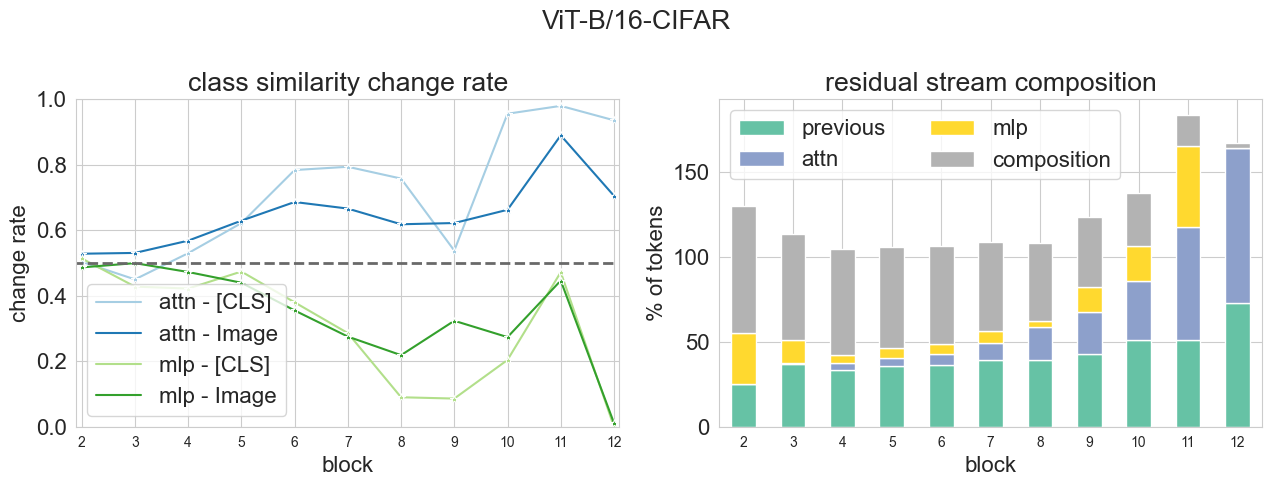

In [19]:
plot_class_building('vit_cifar_16', RES_PATH, CIFAR_PATH)

#### ViT-B/16 - Refinement

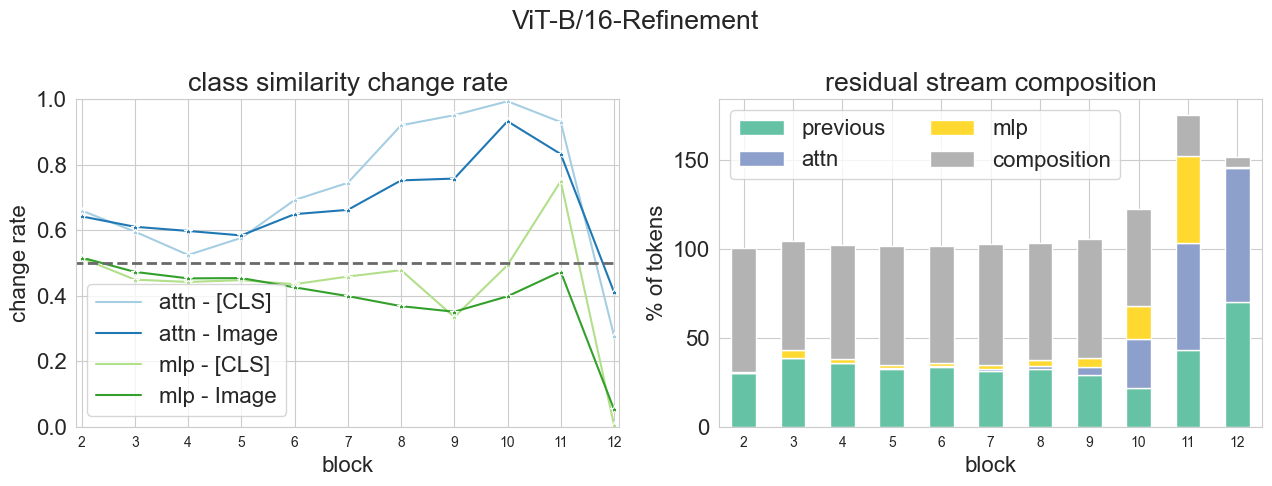

In [21]:
plot_class_building('deit_ensemble_16', RES_PATH, DATASET_PATH)

#### ViT-B/16 - GAP

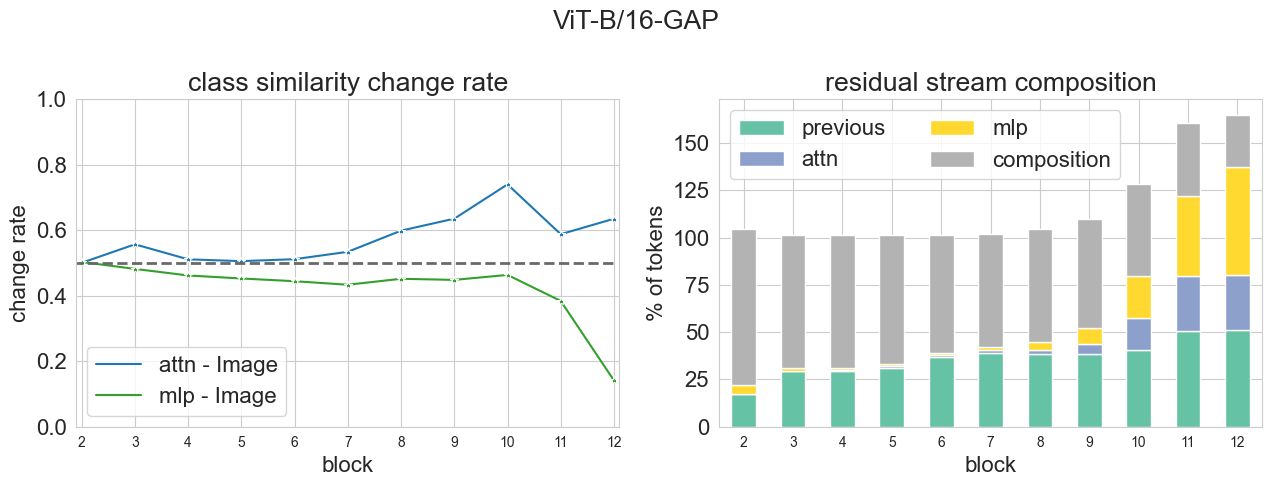

In [22]:
plot_class_building('vit_gap_16', RES_PATH, DATASET_PATH)

### Difference in class similarity change rate between class and context-labeled tokens

We additionally compare the change rate of class- and context-labeled tokens in self-attention layers.

In [9]:
from src.plots.mech_interp import compute_context_diff

Change the `model` variable to print results for different ViT variants.

In [10]:
model = 'vit_b_32'

df = compute_context_diff(model, 'attn', PROJ_PATH, DATASET_PATH)
display(df)

,diffs,pvals,model,layer,block
0,0.007023,0.216667,vit_b_32,attn,0
1,0.029557,0.000000,vit_b_32,attn,1
2,0.127190,0.000000,vit_b_32,attn,2
3,0.215745,0.000000,vit_b_32,attn,3
4,0.231144,0.000000,vit_b_32,attn,4
5,0.232179,0.000000,vit_b_32,attn,5
6,0.343491,0.000000,vit_b_32,attn,6
7,0.435765,0.000000,vit_b_32,attn,7
8,-0.409439,1.000000,vit_b_32,attn,8
9,-0.563637,1.000000,vit_b_32,attn,9


## Categorical updates

To investigate how self-attention and MLP layers carry out categorical updates by promoting class-prototype representations, we project their output parameter matrices into the class-embedding space, by computing $\textbf{P}_{W_{\text{out}}} = \mathbf{E} \cdot \mathbf{W}^T_{\text{out}}$.
The rows of $ \mathbf{E}$ and $\mathbf{W}_{\text{out}}$ are normalized to unit length to enable comparison across ViT variants.

This projection measures the extent to which each row in the output parameter matrices reflects the classes encoded in the embedding space, and thus probes whether the value vectors of the key-value memory pair system have high correspondence with class prototype representations.

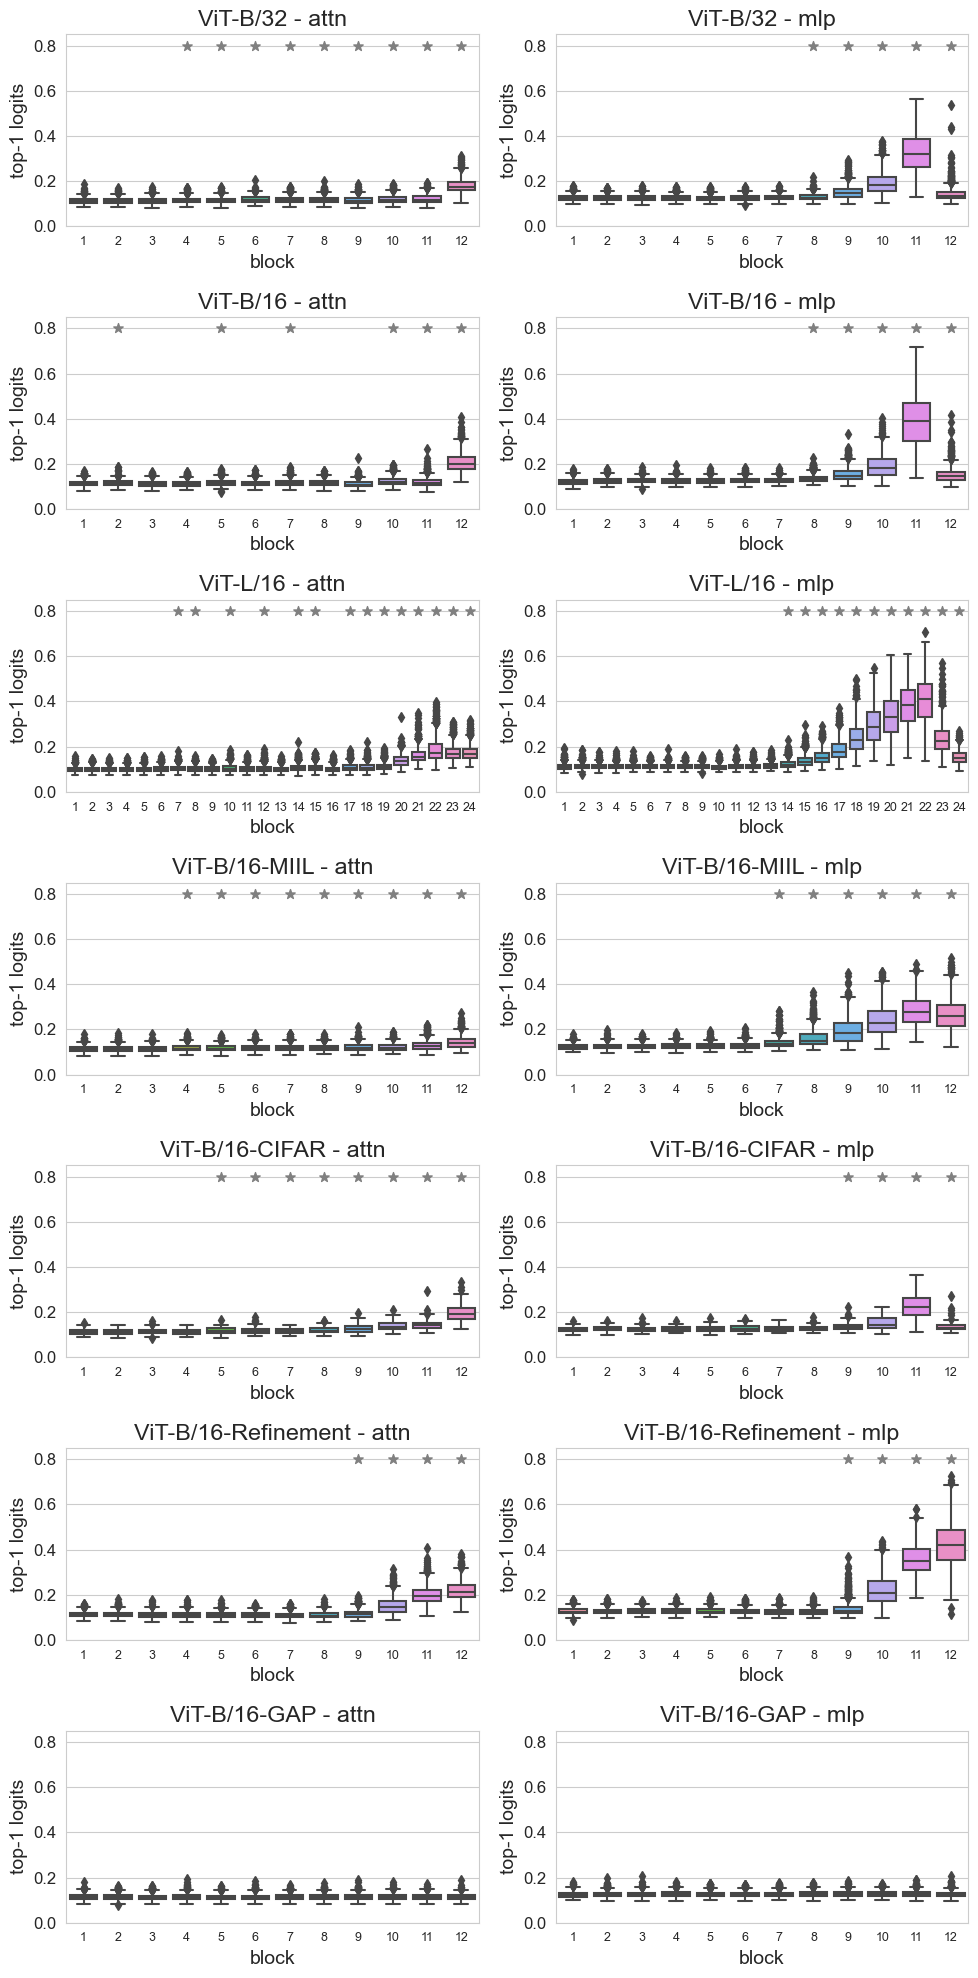

In [9]:
from src.plots.mech_interp import plot_categorical_updates

plot_categorical_updates(PROJ_PATH, DATASET_PATH)

### Human-interpretable value vectors

A manual inspection of the MLP layers containing high class-value agreement scores reveals that value vectors may promote and cluster semantically similar and human-interpretable concepts

In [10]:
# Get dataset info
from src.datasets.imagenet import ImagenetDatasetS

dataset = ImagenetDatasetS(DATASET_PATH)
stim_info = dataset.stim_info

#### ViT-B/32 and MLP layer 11

In [16]:
# Project classes onto values
model = create_model('vit_base_patch32_224', pretrained=True).to(device)
model.eval()
val_proj = model.head.weight @ model.blocks[10].mlp.fc2.weight

# Illustrate the classes with the highest dot product for some example value vectors
for k in [4, 8, 10, 32, 33, 35, 40]:
    print(f'Neuron {k}:')
    top_memories = val_proj[:, k].topk(5, dim=-1)
    for idx in top_memories[1].detach().numpy():
        try:
            cat = dataset.stim_info.loc[dataset.stim_info["index"] == idx]["cat"].unique()[0]
            print(f'{cat}')
        except:
            continue # Ignore classes that are not in Imagenet-S
    print('\n')  

Neuron 4:
racket, racquet
tennis ball
ping-pong ball
volleyball
croquet ball


Neuron 8:
Arctic fox, white fox, Alopex lagopus
brown bear, bruin, Ursus arctos
wombat
American black bear, black bear, Ursus americanus, Euarctos americanus
wild boar, boar, Sus scrofa


Neuron 10:
agama
whiptail, whiptail lizard
alligator lizard
green lizard, Lacerta viridis
American chameleon, anole, Anolis carolinensis


Neuron 32:
groenendael
Scotch terrier, Scottish terrier, Scottie
Afghan hound, Afghan
flat-coated retriever
Newfoundland, Newfoundland dog


Neuron 33:
strawberry
pineapple, ananas
tray
banana


Neuron 35:
rifle
revolver, six-gun, six-shooter
assault rifle, assault gun
scabbard
holster


Neuron 40:
wolf spider, hunting spider
garden spider, Aranea diademata
barn spider, Araneus cavaticus
harvestman, daddy longlegs, Phalangium opilio
spider web, spider's web




#### ViT-B/16 and MLP layer 11

In [17]:
# Project classes onto values
model = create_model('vit_base_patch16_224', pretrained=True).to(device)
val_proj = model.head.weight @ model.blocks[10].mlp.fc2.weight

# Illustrate the classes with the highest dot product for some example value vectors
for k in [2, 7, 14, 18, 21, 24, 26]:
    print(f'Neuron {k}:')
    top_memories = val_proj[:, k].topk(5, dim=-1)
    for idx in top_memories[1].detach().numpy():
        try:
            cat = dataset.stim_info.loc[dataset.stim_info["index"] == idx]["cat"].unique()[0]
            print(f'{cat}')
        except:
            continue
    print('\n')  

Neuron 2:
boathouse
paddle, boat paddle
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis
gondola


Neuron 7:
microphone, mike
radio, wireless
electric guitar
loudspeaker, speaker, speaker unit, loudspeaker system, speaker system


Neuron 14:
screwdriver
carpenter's kit, tool kit
plane, carpenter's plane, woodworking plane
power drill
shovel


Neuron 18:
collie
Border collie
kelpie
kuvasz
Eskimo dog, husky


Neuron 21:
guinea pig, Cavia cobaya
beaver
hare
hamster
catamaran


Neuron 24:
rifle
assault rifle, assault gun
revolver, six-gun, six-shooter
bow
holster


Neuron 26:
drum, membranophone, tympan
maraca
chime, bell, gong
steel drum
drumstick




## Key-value memory pairs at inference time

To investigate if self-attention and MLP layers act as key-value memory pair systems at inference time, we measured how the keys that are most activated during the processing of a sample, correspond to the value vectors that promote the representation of the correct class.

Concretely, for each layer, we quantifY the proportion of tokens where the 5 keys with the highest coefficients are associated with value vectors whose top-5 logits (obtained by the projection $\mathbf{E} \cdot \mathbf{W}_{\text{out}}$) index the correct class.
We call this metric __key-value agreement rate__.

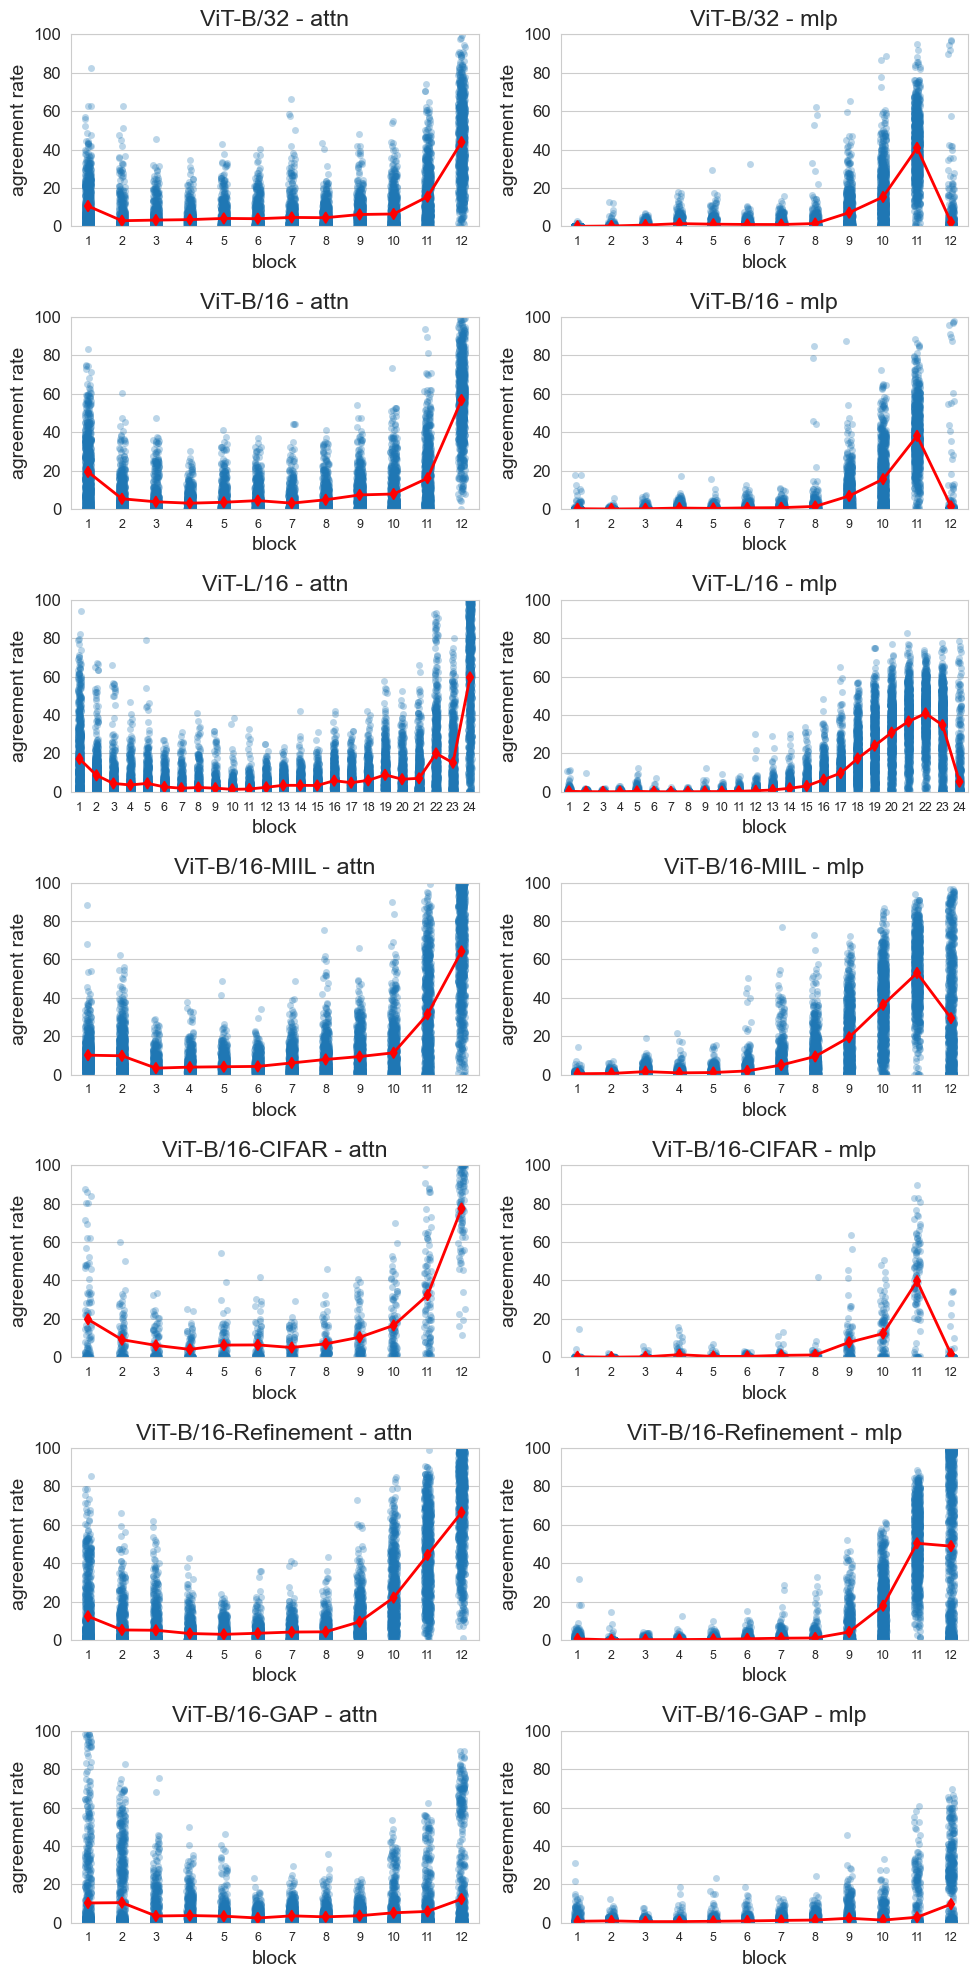

In [8]:
from src.plots.mech_interp import plot_key_value_agreement_rate

plot_key_value_agreement_rate(RES_PATH)

#### Compare memory systems across all ViT variants

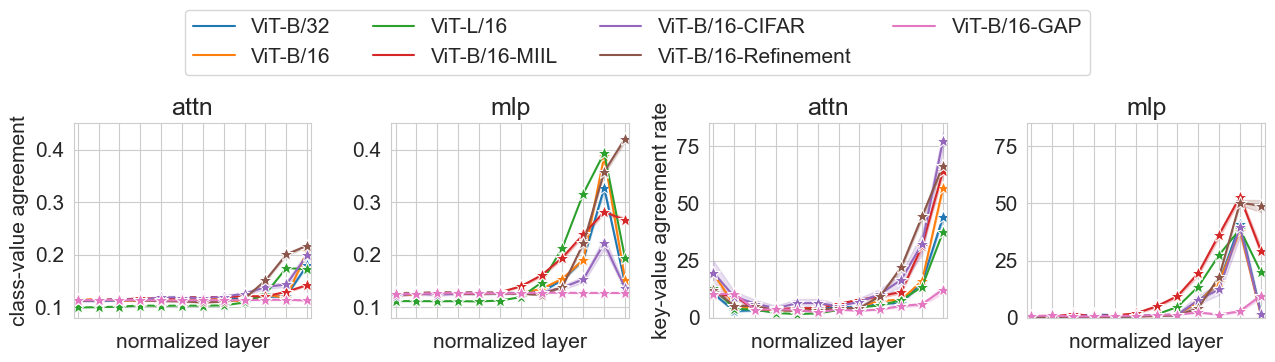

In [8]:
from src.plots.mech_interp import compare_memory_pairs

compare_memory_pairs(PROJ_PATH, DATASET_PATH)

### Agreement rate influence in accuracy

We further evaluate the influence of these findings on the accuracy of the model, and compare the agreement rate of correctly classified vs. misclassified samples. 

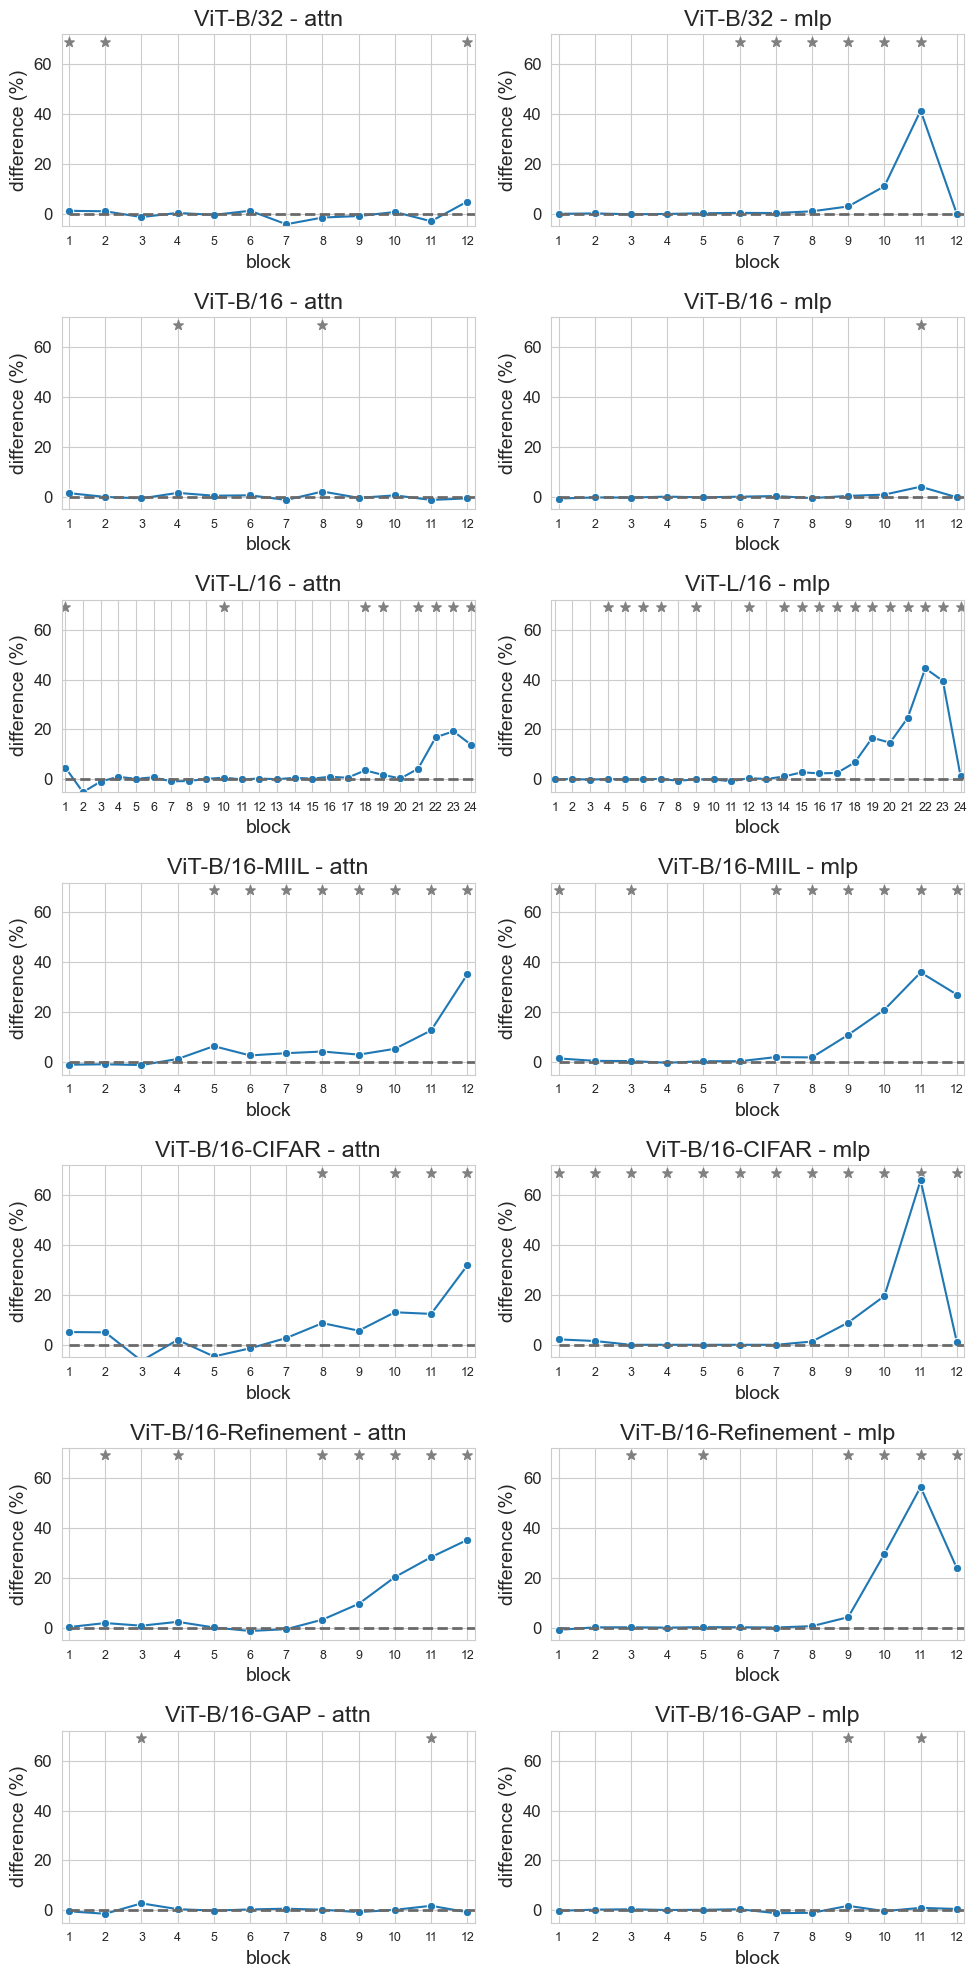

In [8]:
from src.plots.mech_interp import plot_agr_rate_diff

plot_agr_rate_diff(RES_PATH)

## Compositionality of key-value memory pair mechanisms

The final output of a layer may combine the prediction of many key-value memory pairs, and predict a categorical distribution that is different from that of its most activating memories.  We measure the compositionality of a layer's prediction by quantifying the number of instances where the layer's final predictions match any of the predictions of the top-5 most activated memories for that instance.

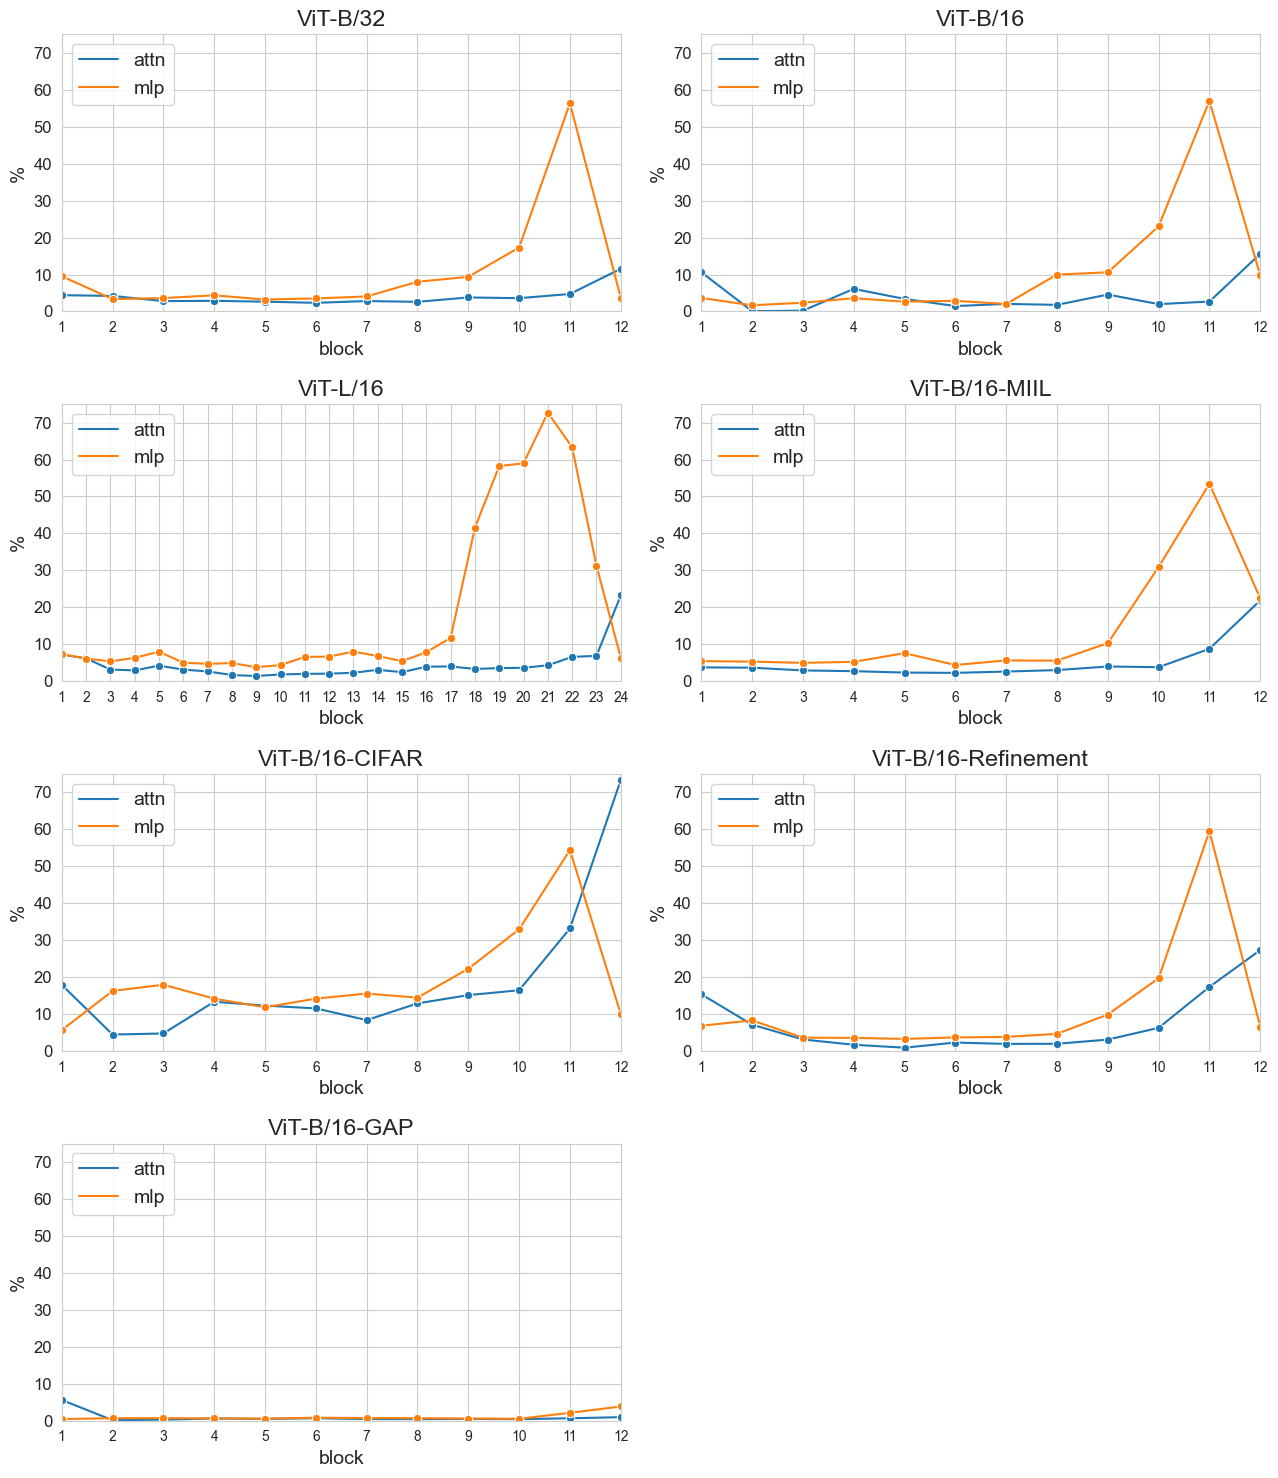

In [8]:
from src.plots.mech_interp import plot_memory_compositionality

plot_memory_compositionality(RES_PATH)